# Reviewing the frequency and intensity of storms in Myanmar

Looking at the scale used here: https://en.wikipedia.org/wiki/Tropical_cyclone_intensity_scales#North_Indian_Ocean

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import calendar

from src.constants import *
from src.codab import *

In [3]:
gdf_adm = load_codab(admin_level=0)
ibtracs_path = Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(ibtracs_path / "IBTrACS.NI.list.v04r01.points.zip")

gdf_points = gpd.read_file(points_path, layer="IBTrACS.NI.list.v04r01.points")

Looking at which months cyclones happen in.

In [4]:
gdf_points_1980 = gdf_points[gdf_points["year"] >= 1980]
gdf_points_1980[["NAME", "NEW_WIND"]]  # it seems some values are missing here.

,NAME,NEW_WIND
44680,UNNAMED,NaN
44681,UNNAMED,NaN
44682,UNNAMED,NaN
44683,UNNAMED,NaN
44684,UNNAMED,NaN
...,...,...
62043,FENGAL,NaN
62044,FENGAL,NaN
62045,FENGAL,NaN
62046,FENGAL,NaN


In [5]:
# filling in missing values with those from USA and converting 1-minute to 3-minute winds.
gdf_points_1980.loc[:, "NEW_USA_WIND"] = gdf_points_1980["NEW_WIND"].fillna(
    gdf_points_1980["USA_WIND"] * 0.93
)

c:\Users\pauni\Desktop\Work\OCHA\GitHub\ds-aa-mmr-cyclones\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [22]:
adm_buffer = 0  # Use 0, 50 or 100: these are in km
gdf_adm_projected = gdf_adm.to_crs(epsg=MMR_UTM)
gdf_adm_projected["geometry"] = gdf_adm_projected.geometry.buffer(
    adm_buffer * 1000
)
gdf_adm_buffered = gdf_adm_projected.to_crs(gdf_adm.crs)
gdf_points_adm = gpd.sjoin(
    gdf_points_1980, gdf_adm_buffered, how="inner", predicate="intersects"
)

<Axes: >

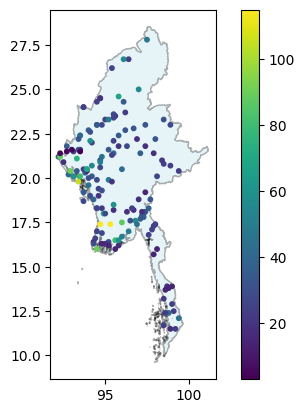

In [23]:
ax = gdf_adm.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_adm.plot(ax=ax, column="NEW_USA_WIND", markersize=10, legend=True)

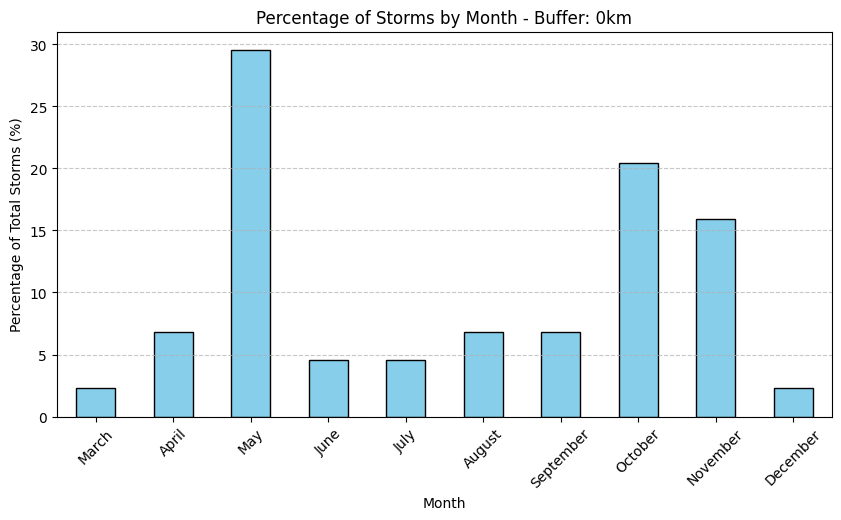

In [24]:
month_counts = gdf_points_adm.groupby("month")["SID"].nunique()

total_storms = gdf_points_adm["SID"].nunique()
month_percent = (month_counts / total_storms) * 100

month_labels = [calendar.month_name[m] for m in month_counts.index]

plt.figure(figsize=(10, 5))
month_percent.plot(kind="bar", color="skyblue", edgecolor="black")

# Labels and title
plt.xlabel("Month")
plt.ylabel("Percentage of Total Storms (%)")
plt.title(f"Percentage of Storms by Month - Buffer: {adm_buffer}km")
plt.xticks(ticks=range(len(month_labels)), labels=month_labels, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Looking at frequency of different intensities

In [25]:
bins = [0, 16, 27, 33, 47, 63, 89, 119, float("inf")]
labels = [
    "Below Depression",
    "Depression",
    "Deep Depression",
    "Cyclonic Storm",
    "Severe Cyclonic Storm",
    "Very Severe Cyclonic Storm",
    "Extremely Severe Cyclonic Storm",
    "Super Cyclonic Storm",
]
gdf_points_adm["IMD_SCALE"] = pd.cut(
    gdf_points_adm["NEW_USA_WIND"], bins=bins, labels=labels, right=True
)
gdf_points_adm[["NEW_USA_WIND", "IMD_SCALE"]].head(10)

,NEW_USA_WIND,IMD_SCALE
45270,115.00,Extremely Severe Cyclonic Storm
45271,115.00,Extremely Severe Cyclonic Storm
45272,87.00,Very Severe Cyclonic Storm
45273,58.00,Severe Cyclonic Storm
45274,39.00,Cyclonic Storm
45275,30.00,Deep Depression
45276,37.20,Cyclonic Storm
45277,35.34,Cyclonic Storm
45278,32.55,Deep Depression
45279,NaN,NaN


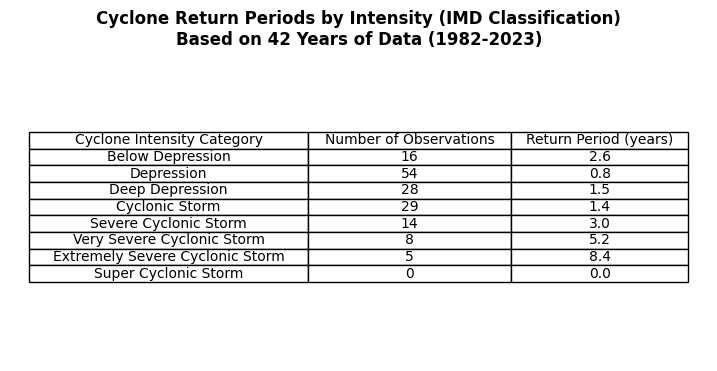

In [26]:
min_year = gdf_points_adm["year"].min()
max_year = gdf_points_adm["year"].max()
total_years = max_year - min_year + 1
intensity_counts = (
    gdf_points_adm["IMD_SCALE"].value_counts().reindex(labels, fill_value=0)
)
return_periods = total_years / intensity_counts.replace(0, float("inf"))
df_table = pd.DataFrame(
    {
        "Cyclone Intensity Category": labels,
        "Number of Observations": intensity_counts.values,
        "Return Period (years)": return_periods.round(
            1
        ),  # Round to 1 decimal place
    }
)
fig, ax = plt.subplots(figsize=(9, 4))
ax.axis("tight")
ax.axis("off")
table = ax.table(
    cellText=df_table.values,
    colLabels=df_table.columns,
    cellLoc="center",
    loc="center",
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2])

plt.title(
    f"Cyclone Return Periods by Intensity (IMD Classification)\nBased on {total_years} Years of Data ({min_year}-{max_year})",
    fontsize=12,
    weight="bold",
)
plt.show()